# Benchmark: STGNN vs Transformer vs STGNN+Transformer
## Perbandingan dengan Config yang SAMA

Semua model menggunakan:
- `HIDDEN_DIM = 128`
- `NUM_GCN_LAYERS = 3`
- `MAX_NODES = 300`
- `MAX_SEGMENTS = 8`
- `BATCH_ACCUM = 4`

In [1]:
# Cell 1: Imports
import os, gc, json, time, random, warnings
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, precision_recall_curve, precision_score, recall_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
warnings.filterwarnings('ignore')
print('Libraries loaded!')

c:\Users\MAHARDIKA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded!


In [2]:
# Cell 2: Configuration
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

ROOT = Path('DatasetTA')
GRAPHS_DIR = ROOT / 'project_data' / 'graphs'
MODELS_DIR = ROOT / 'project_data' / 'models'
ANALYSIS_DIR = ROOT / 'project_data' / 'analysis'
for p in [MODELS_DIR, ANALYSIS_DIR]: p.mkdir(parents=True, exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
USE_AMP = torch.cuda.is_available()

# ============================================
# CONFIG YANG SAMA UNTUK SEMUA MODEL
# ============================================
HIDDEN_DIM = 128
OUTPUT_DIM = 128
NUM_GCN_LAYERS = 3
DROPOUT = 0.3

EPOCHS = 15
LR = 5e-4
BATCH_ACCUM = 4
MAX_SEGMENTS = 8
MAX_NODES = 300
PATIENCE = 5
LABEL_SMOOTHING = 0.1

ANOM_CLASSES = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion',
                'Fighting','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

print('='*60)
print('BENCHMARK CONFIG')
print('='*60)
print(f'Device: {DEVICE}')
print(f'HIDDEN_DIM: {HIDDEN_DIM}')
print(f'NUM_GCN_LAYERS: {NUM_GCN_LAYERS}')
print(f'MAX_NODES: {MAX_NODES}')
print(f'MAX_SEGMENTS: {MAX_SEGMENTS}')
print(f'BATCH_ACCUM: {BATCH_ACCUM}')
print(f'EPOCHS: {EPOCHS}')

BENCHMARK CONFIG
Device: cuda
HIDDEN_DIM: 128
NUM_GCN_LAYERS: 3
MAX_NODES: 300
MAX_SEGMENTS: 8
BATCH_ACCUM: 4
EPOCHS: 15


In [3]:
# Cell 3: Utility Functions
def augment_features(x):
    if x.size(1) == 5:
        x1,y1,x2,y2,conf = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4]
        w, h = (x2-x1).clamp(min=1), (y2-y1).clamp(min=1)
        x = torch.cat([x, w.unsqueeze(1), h.unsqueeze(1), (w*h).unsqueeze(1),
                       (0.5*(x1+x2)).unsqueeze(1), (0.5*(y1+y2)).unsqueeze(1)], dim=1)
    return x

def norm_feat(x):
    x = augment_features(x)
    fmin, fmax = x.min(0).values, x.max(0).values
    return (x - fmin) / (fmax - fmin).clamp(min=1e-6)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.alpha, self.gamma, self.ls = alpha, gamma, label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, label_smoothing=self.ls, reduction='none')
        return (((1 - torch.exp(-ce)) ** self.gamma) * ce).mean()

def limit_nodes(g, max_nodes=MAX_NODES):
    if g.x.size(0) <= max_nodes: return g
    idx = torch.randperm(g.x.size(0))[:max_nodes].sort().values
    N = g.x.size(0)
    mask = torch.zeros(N, dtype=torch.bool); mask[idx] = True
    if g.edge_index.numel() > 0:
        em = mask[g.edge_index[0]] & mask[g.edge_index[1]]
        ei = g.edge_index[:, em]
        mp = torch.full((N,), -1, dtype=torch.long); mp[idx] = torch.arange(len(idx))
        ei = mp[ei]
    else: ei = torch.empty((2,0), dtype=torch.long)
    new_g = Data(x=g.x[idx], edge_index=ei)
    if hasattr(g, 'node_frames'): new_g.node_frames = g.node_frames[idx]
    return new_g

def split_segments(g, max_seg=MAX_SEGMENTS):
    g = limit_nodes(g)
    if not hasattr(g, 'node_frames') or g.node_frames is None: return [g]
    frames = g.node_frames.cpu().numpy()
    uniq = np.unique(frames)
    groups = [[f] for f in uniq] if len(uniq) <= max_seg else np.array_split(uniq, max_seg)
    segs = []
    for gr in groups:
        if len(gr) == 0: continue
        mask = np.isin(frames, gr)
        idx = torch.tensor(np.where(mask)[0], dtype=torch.long)
        if len(idx) == 0: continue
        N = g.x.size(0)
        m = torch.zeros(N, dtype=torch.bool); m[idx] = True
        if g.edge_index.numel() > 0:
            em = m[g.edge_index[0]] & m[g.edge_index[1]]
            ei = g.edge_index[:, em]
            mp = torch.full((N,), -1, dtype=torch.long); mp[idx] = torch.arange(len(idx))
            ei = mp[ei]
        else: ei = torch.empty((2,0), dtype=torch.long)
        segs.append(Data(x=g.x[idx], edge_index=ei))
    return segs if segs else [g]

print('Utility functions defined!')

Utility functions defined!


In [4]:
# Cell 4: Dataset
class GraphVideoDataset(Dataset):
    def __init__(self, graphs_dir, split='train', ratio=0.85, seed=SEED):
        graph_files = sorted(Path(graphs_dir).rglob('*_graph.pt'))
        anom, norm = [], []
        for gp in graph_files:
            path_str = '/'.join(gp.parts)
            is_anom = any(c in path_str for c in ANOM_CLASSES)
            (anom if is_anom else norm).append((gp, int(is_anom)))
        
        rng = np.random.RandomState(seed)
        ai, ni = np.arange(len(anom)), np.arange(len(norm))
        rng.shuffle(ai); rng.shuffle(ni)
        asp, nsp = int(ratio*len(ai)), int(ratio*len(ni))
        
        if split == 'train':
            self.items = [anom[i] for i in ai[:asp]] + [norm[i] for i in ni[:nsp]]
        else:
            self.items = [anom[i] for i in ai[asp:]] + [norm[i] for i in ni[nsp:]]
        rng.shuffle(self.items)
        self.n_anom = sum(1 for _,l in self.items if l==1)
        self.n_norm = len(self.items) - self.n_anom
    
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        gp, lab = self.items[i]
        return torch.load(gp, weights_only=False), lab, gp.stem.replace('_graph','')

# Load datasets
train_ds = GraphVideoDataset(GRAPHS_DIR, 'train', 0.85, SEED)
val_ds = GraphVideoDataset(GRAPHS_DIR, 'val', 0.85, SEED)
print(f'Train: {len(train_ds)} (Anom:{train_ds.n_anom}, Norm:{train_ds.n_norm})')
print(f'Val: {len(val_ds)} (Anom:{val_ds.n_anom}, Norm:{val_ds.n_norm})')

Train: 1650 (Anom:677, Norm:973)
Val: 292 (Anom:120, Norm:172)


In [5]:
# Cell 5: Model Definitions

# MODEL 1: STGNN ONLY
class STGNNOnly(nn.Module):
    def __init__(self, in_dim=10, hid=HIDDEN_DIM, out=OUTPUT_DIM, layers=NUM_GCN_LAYERS, drop=DROPOUT):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.LayerNorm(hid), nn.GELU(), nn.Dropout(drop))
        self.convs = nn.ModuleList([GCNConv(hid, hid) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hid) for _ in range(layers)])
        self.att = nn.Sequential(nn.Linear(hid, hid//2), nn.Tanh(), nn.Linear(hid//2, 1))
        self.proj = nn.Linear(hid, out)
        self.cls = nn.Sequential(nn.Linear(out, out//2), nn.GELU(), nn.Dropout(drop), nn.Linear(out//2, 2))
    
    def forward_single(self, x, ei):
        h = self.enc(norm_feat(x))
        for conv, ln in zip(self.convs, self.norms):
            h = h + F.gelu(ln(conv(h, ei)))
        att = torch.softmax(self.att(h).squeeze(-1), 0)
        return self.proj((h * att.unsqueeze(-1)).sum(0, keepdim=True))
    
    def forward(self, segs):
        dev = next(self.parameters()).device
        feats = [self.forward_single(g.x.to(dev), g.edge_index.to(dev) if g.edge_index.numel()>0 
                           else torch.empty((2,0), dtype=torch.long, device=dev)) for g in segs]
        pooled = torch.cat(feats, 0).mean(0, keepdim=True)
        return self.cls(pooled)

# MODEL 2: TRANSFORMER ONLY
class TransformerOnly(nn.Module):
    def __init__(self, in_dim=10, hid=HIDDEN_DIM, out=OUTPUT_DIM, heads=4, layers=2, drop=DROPOUT):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.LayerNorm(hid), nn.GELU(), nn.Dropout(drop))
        self.att = nn.Sequential(nn.Linear(hid, hid//2), nn.Tanh(), nn.Linear(hid//2, 1))
        self.proj = nn.Linear(hid, out)
        enc_layer = nn.TransformerEncoderLayer(out, heads, out*2, drop, 'gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, layers)
        self.cls = nn.Sequential(nn.Linear(out, out//2), nn.GELU(), nn.Dropout(drop), nn.Linear(out//2, 2))
    
    def forward_single(self, x):
        h = self.enc(norm_feat(x))
        att = torch.softmax(self.att(h).squeeze(-1), 0)
        return self.proj((h * att.unsqueeze(-1)).sum(0, keepdim=True))
    
    def forward(self, segs):
        dev = next(self.parameters()).device
        feats = [self.forward_single(g.x.to(dev)) for g in segs]
        seq = torch.cat(feats, 0).unsqueeze(0)
        out = self.transformer(seq).mean(1)
        return self.cls(out)

# MODEL 3: STGNN + TRANSFORMER (Full Hybrid)
class STGNN(nn.Module):
    def __init__(self, in_dim=10, hid=HIDDEN_DIM, out=OUTPUT_DIM, layers=NUM_GCN_LAYERS, drop=DROPOUT):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.LayerNorm(hid), nn.GELU(), nn.Dropout(drop))
        self.convs = nn.ModuleList([GCNConv(hid, hid) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hid) for _ in range(layers)])
        self.att = nn.Sequential(nn.Linear(hid, hid//2), nn.Tanh(), nn.Linear(hid//2, 1))
        self.proj = nn.Linear(hid, out)
    
    def forward(self, x, ei):
        h = self.enc(norm_feat(x))
        for conv, ln in zip(self.convs, self.norms):
            h = h + F.gelu(ln(conv(h, ei)))
        att = torch.softmax(self.att(h).squeeze(-1), 0)
        return self.proj((h * att.unsqueeze(-1)).sum(0, keepdim=True))

class Transformer(nn.Module):
    def __init__(self, dim=OUTPUT_DIM, heads=4, layers=2, drop=DROPOUT):
        super().__init__()
        enc = nn.TransformerEncoderLayer(dim, heads, dim*2, drop, 'gelu', batch_first=True)
        self.enc = nn.TransformerEncoder(enc, layers)
    def forward(self, x): return self.enc(x).mean(1)

class STGNNTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.stgnn = STGNN()
        self.trans = Transformer()
        self.cls = nn.Sequential(nn.Linear(OUTPUT_DIM, OUTPUT_DIM//2), nn.GELU(), 
                                nn.Dropout(DROPOUT), nn.Linear(OUTPUT_DIM//2, 2))
    
    def forward(self, segs):
        dev = next(self.parameters()).device
        feats = [self.stgnn(g.x.to(dev), g.edge_index.to(dev) if g.edge_index.numel()>0 
                           else torch.empty((2,0), dtype=torch.long, device=dev)) for g in segs]
        return self.cls(self.trans(torch.cat(feats, 0).unsqueeze(0)))

# Verify parameter counts
print('\nParameter Count:')
print('='*50)
m1 = STGNNOnly(); m2 = TransformerOnly(); m3 = STGNNTransformer()
p1 = sum(p.numel() for p in m1.parameters())
p2 = sum(p.numel() for p in m2.parameters())
p3 = sum(p.numel() for p in m3.parameters())
print(f'STGNN Only:           {p1:>10,} params')
print(f'Transformer Only:     {p2:>10,} params')
print(f'STGNN + Transformer:  {p3:>10,} params')
print('='*50)
del m1, m2, m3


Parameter Count:
STGNN Only:               85,187 params
Transformer Only:        299,843 params
STGNN + Transformer:     350,147 params


In [6]:
# Cell 6: Training Functions
def train_epoch(model, ds, opt, crit, scaler, dev, accum=BATCH_ACCUM):
    model.train(); loss_sum, correct, n = 0, 0, 0
    opt.zero_grad()
    for i, (g, lab, _) in enumerate(tqdm(ds, leave=False, desc='Train')):
        segs = split_segments(g)
        y = torch.tensor([lab], dtype=torch.long, device=dev)
        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(segs)
            loss = crit(logits, y) / accum
        scaler.scale(loss).backward()
        if (i+1) % accum == 0 or i+1 == len(ds):
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update(); opt.zero_grad()
        loss_sum += loss.item() * accum
        correct += int(logits.argmax(1).item() == lab)
        n += 1
        if i % 50 == 0: torch.cuda.empty_cache()
    return loss_sum/n, correct/n

@torch.no_grad()
def evaluate(model, ds, crit, dev):
    model.eval(); loss_sum, correct, n = 0, 0, 0
    ys, ps = [], []
    for i, (g, lab, _) in enumerate(tqdm(ds, leave=False, desc='Eval')):
        segs = split_segments(g)
        y = torch.tensor([lab], dtype=torch.long, device=dev)
        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(segs)
            loss = crit(logits, y)
        prob = torch.softmax(logits, 1)[0,1].cpu().item()
        loss_sum += loss.item()
        correct += int(logits.argmax(1).item() == lab)
        n += 1; ys.append(lab); ps.append(prob)
        if i % 50 == 0: torch.cuda.empty_cache()
    
    auc = roc_auc_score(ys, ps) if len(set(ys)) > 1 else 0.5
    prec, rec, thrs = precision_recall_curve(ys, ps)
    f1s = 2 * prec * rec / (prec + rec + 1e-8)
    best_idx = np.argmax(f1s)
    best_thr = thrs[best_idx] if best_idx < len(thrs) else 0.5
    best_f1 = f1s[best_idx]
    preds = [1 if p >= best_thr else 0 for p in ps]
    prec_score = precision_score(ys, preds, zero_division=0)
    rec_score = recall_score(ys, preds, zero_division=0)
    
    return {'loss': loss_sum/n, 'acc': correct/n, 'auc': auc, 'best_f1': best_f1, 
            'best_thr': best_thr, 'precision': prec_score, 'recall': rec_score,
            'ys': ys, 'ps': ps, 'preds': preds}

@torch.no_grad()
def measure_inference_time(model, ds, dev, num_samples=50, warmup=5):
    model.eval(); model = model.to(dev)
    for i in range(min(warmup, len(ds))):
        g, _, _ = ds[i]
        segs = split_segments(g)
        with torch.amp.autocast('cuda', enabled=USE_AMP): _ = model(segs)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    times = []
    for i in range(min(num_samples, len(ds))):
        g, _, _ = ds[i]
        segs = split_segments(g)
        if torch.cuda.is_available(): torch.cuda.synchronize()
        start = time.perf_counter()
        with torch.amp.autocast('cuda', enabled=USE_AMP): _ = model(segs)
        if torch.cuda.is_available(): torch.cuda.synchronize()
        times.append((time.perf_counter() - start) * 1000)
    return {'mean_ms': np.mean(times), 'std_ms': np.std(times), 'fps': 1000 / np.mean(times)}

def train_model(model, model_name, train_ds, val_ds, epochs=EPOCHS):
    print(f'\n{"="*60}')
    print(f'Training: {model_name}')
    print(f'{"="*60}')
    params = sum(p.numel() for p in model.parameters())
    print(f'Parameters: {params:,}')
    
    model = model.to(DEVICE)
    pos_weight = train_ds.n_norm / max(train_ds.n_anom, 1)
    alpha = torch.tensor([1.0, pos_weight], device=DEVICE)
    criterion = FocalLoss(alpha, gamma=2.0, label_smoothing=LABEL_SMOOTHING)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
    scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)
    
    best_auc, best_results = 0, None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}
    patience_counter = 0
    save_name = model_name.lower().replace(' ', '_').replace('+', '_')
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_ds, optimizer, criterion, scaler, DEVICE)
        val_results = evaluate(model, val_ds, criterion, DEVICE)
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_results['loss'])
        history['val_acc'].append(val_results['acc'])
        history['val_auc'].append(val_results['auc'])
        
        print(f"Ep{epoch+1:02d}: TrL={train_loss:.4f} TrA={train_acc:.4f} | "
              f"VaL={val_results['loss']:.4f} VaA={val_results['acc']:.4f} AUC={val_results['auc']:.4f} F1={val_results['best_f1']:.4f}")
        
        if val_results['auc'] > best_auc:
            best_auc = val_results['auc']
            best_results = val_results.copy()
            patience_counter = 0
            torch.save(model.state_dict(), MODELS_DIR / f'benchmark_{save_name}.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'Early stopping at epoch {epoch+1}')
                break
        torch.cuda.empty_cache(); gc.collect()
    
    return {
        'model_name': model_name,
        'params': params,
        'best_auc': best_auc,
        'best_f1': best_results['best_f1'],
        'best_thr': best_results['best_thr'],
        'accuracy': best_results['acc'],
        'precision': best_results['precision'],
        'recall': best_results['recall'],
        'history': history,
        'ys': best_results['ys'],
        'ps': best_results['ps'],
        'preds': best_results['preds']
    }

print('Training functions defined!')

Training functions defined!


In [7]:
# Cell 7: Run Training
results = []

# Model 1: STGNN Only
model1 = STGNNOnly()
results.append(train_model(model1, 'STGNN Only', train_ds, val_ds))
results[-1].update(measure_inference_time(model1, val_ds, DEVICE))
del model1; torch.cuda.empty_cache(); gc.collect()

# Model 2: Transformer Only
model2 = TransformerOnly()
results.append(train_model(model2, 'Transformer Only', train_ds, val_ds))
results[-1].update(measure_inference_time(model2, val_ds, DEVICE))
del model2; torch.cuda.empty_cache(); gc.collect()

# Model 3: STGNN + Transformer
model3 = STGNNTransformer()
results.append(train_model(model3, 'STGNN + Transformer', train_ds, val_ds))
results[-1].update(measure_inference_time(model3, val_ds, DEVICE))
del model3; torch.cuda.empty_cache(); gc.collect()

print('\n' + '='*60)
print('TRAINING COMPLETE!')
print('='*60)


Training: STGNN Only
Parameters: 85,187


Ep01: TrL=0.2649 TrA=0.5479 | VaL=0.2442 VaA=0.5342 AUC=0.7272 F1=0.6485


Ep02: TrL=0.2520 TrA=0.6152 | VaL=0.2404 VaA=0.5548 AUC=0.7500 F1=0.6740


Ep03: TrL=0.2440 TrA=0.6515 | VaL=0.2421 VaA=0.5719 AUC=0.7270 F1=0.6450


Ep04: TrL=0.2411 TrA=0.6479 | VaL=0.2315 VaA=0.6199 AUC=0.7469 F1=0.6565


Ep05: TrL=0.2385 TrA=0.6606 | VaL=0.2465 VaA=0.6062 AUC=0.7355 F1=0.6516


Ep06: TrL=0.2404 TrA=0.6685 | VaL=0.2539 VaA=0.6610 AUC=0.7372 F1=0.6618


Ep07: TrL=0.2378 TrA=0.6800 | VaL=0.2526 VaA=0.6610 AUC=0.7292 F1=0.6551
Early stopping at epoch 7

Training: Transformer Only
Parameters: 299,843


Ep01: TrL=0.2671 TrA=0.5109 | VaL=0.2519 VaA=0.4589 AUC=0.7334 F1=0.6447


Ep02: TrL=0.2542 TrA=0.5976 | VaL=0.2282 VaA=0.6541 AUC=0.7593 F1=0.6901


Ep03: TrL=0.2455 TrA=0.6358 | VaL=0.2288 VaA=0.6267 AUC=0.7587 F1=0.6960


Ep04: TrL=0.2373 TrA=0.6794 | VaL=0.2312 VaA=0.6986 AUC=0.7665 F1=0.6746


Ep05: TrL=0.2428 TrA=0.6636 | VaL=0.2447 VaA=0.6815 AUC=0.7427 F1=0.6690


Ep06: TrL=0.2414 TrA=0.6564 | VaL=0.2593 VaA=0.7089 AUC=0.7614 F1=0.6603


Ep07: TrL=0.2378 TrA=0.6576 | VaL=0.2403 VaA=0.6849 AUC=0.7618 F1=0.6810


Ep08: TrL=0.2333 TrA=0.6715 | VaL=0.2361 VaA=0.7021 AUC=0.7724 F1=0.6779


Ep09: TrL=0.2325 TrA=0.6836 | VaL=0.2687 VaA=0.7123 AUC=0.7417 F1=0.6529


Ep10: TrL=0.2283 TrA=0.6982 | VaL=0.2384 VaA=0.6986 AUC=0.7830 F1=0.6951


Ep11: TrL=0.2281 TrA=0.7055 | VaL=0.2347 VaA=0.7260 AUC=0.7893 F1=0.6939


Ep12: TrL=0.2270 TrA=0.7085 | VaL=0.2340 VaA=0.7055 AUC=0.7688 F1=0.7006


Ep13: TrL=0.2245 TrA=0.7133 | VaL=0.2319 VaA=0.7055 AUC=0.7795 F1=0.6921


Ep14: TrL=0.2250 TrA=0.7091 | VaL=0.2523 VaA=0.6815 AUC=0.7509 F1=0.6689


Ep15: TrL=0.2243 TrA=0.7061 | VaL=0.2336 VaA=0.7123 AUC=0.7852 F1=0.7018

Training: STGNN + Transformer
Parameters: 350,147


Ep01: TrL=0.2699 TrA=0.4618 | VaL=0.2606 VaA=0.4110 AUC=0.4764 F1=0.5825


Ep02: TrL=0.2653 TrA=0.4976 | VaL=0.3640 VaA=0.5616 AUC=0.4055 F1=0.5825


Ep03: TrL=0.2642 TrA=0.5224 | VaL=0.2426 VaA=0.6884 AUC=0.6977 F1=0.6475


Ep04: TrL=0.2558 TrA=0.5970 | VaL=0.2341 VaA=0.6336 AUC=0.7405 F1=0.6567


Ep05: TrL=0.2430 TrA=0.6261 | VaL=0.2409 VaA=0.7021 AUC=0.7348 F1=0.6474


Ep06: TrL=0.2412 TrA=0.6406 | VaL=0.2565 VaA=0.6644 AUC=0.7171 F1=0.6624


Ep07: TrL=0.2401 TrA=0.6552 | VaL=0.2464 VaA=0.6712 AUC=0.7273 F1=0.6465


Ep08: TrL=0.2378 TrA=0.6673 | VaL=0.2417 VaA=0.6815 AUC=0.7503 F1=0.6756


Ep09: TrL=0.2406 TrA=0.6721 | VaL=0.2510 VaA=0.6815 AUC=0.7452 F1=0.6667


Ep10: TrL=0.2322 TrA=0.6836 | VaL=0.2376 VaA=0.6747 AUC=0.7258 F1=0.6643


Ep11: TrL=0.2299 TrA=0.6873 | VaL=0.2333 VaA=0.6849 AUC=0.7393 F1=0.6667


Ep12: TrL=0.2259 TrA=0.7042 | VaL=0.2324 VaA=0.6986 AUC=0.7552 F1=0.6644


Ep13: TrL=0.2255 TrA=0.7042 | VaL=0.2360 VaA=0.6815 AUC=0.7494 F1=0.6923


Ep14: TrL=0.2252 TrA=0.7018 | VaL=0.2385 VaA=0.6849 AUC=0.7450 F1=0.6714


Ep15: TrL=0.2221 TrA=0.7103 | VaL=0.2444 VaA=0.6849 AUC=0.7309 F1=0.6715

TRAINING COMPLETE!


In [8]:
# Cell 8: Results Summary
print('\n' + '='*110)
print('HASIL BENCHMARK')
print('='*110)
print(f'{"Model":<25} | {"Params":>10} | {"Accuracy":>8} | {"AUC-ROC":>8} | {"F1":>8} | {"Precision":>9} | {"Recall":>8} | {"Time(ms)":>9}')
print('-'*110)

for r in results:
    print(f"{r['model_name']:<25} | {r['params']:>10,} | {r['accuracy']*100:>7.2f}% | {r['best_auc']:>8.4f} | {r['best_f1']:>8.4f} | {r['precision']:>9.4f} | {r['recall']:>8.4f} | {r['mean_ms']:>9.2f}")

print('-'*110)
best = max(results, key=lambda x: x['best_auc'])
print(f"\nBest Model: {best['model_name']} (AUC: {best['best_auc']:.4f})")


HASIL BENCHMARK
Model                     |     Params | Accuracy |  AUC-ROC |       F1 | Precision |   Recall |  Time(ms)
--------------------------------------------------------------------------------------------------------------
STGNN Only                |     85,187 |   55.48% |   0.7500 |   0.6740 |    0.6013 |   0.7667 |     31.71
Transformer Only          |    299,843 |   72.60% |   0.7893 |   0.6939 |    0.5862 |   0.8500 |      9.71
STGNN + Transformer       |    350,147 |   69.86% |   0.7552 |   0.6644 |    0.5562 |   0.8250 |     34.49
--------------------------------------------------------------------------------------------------------------

Best Model: Transformer Only (AUC: 0.7893)


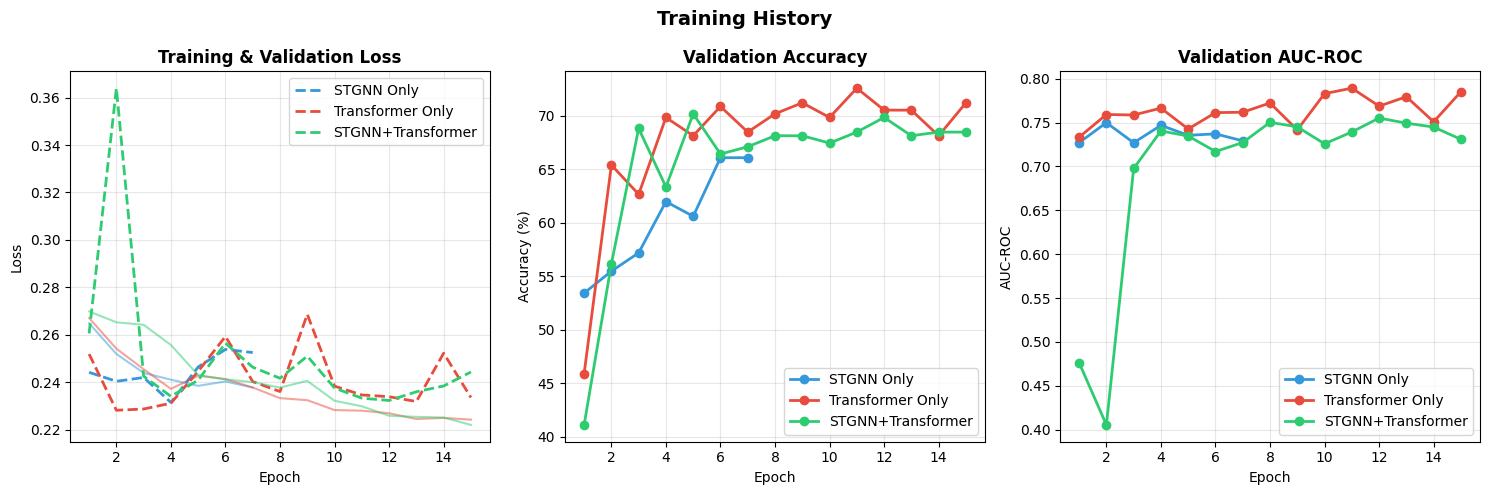

In [9]:
# Cell 9: Training History
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']
labels = ['STGNN Only', 'Transformer Only', 'STGNN+Transformer']

for idx, r in enumerate(results):
    epochs = range(1, len(r['history']['train_loss'])+1)
    axes[0].plot(epochs, r['history']['train_loss'], '-', color=colors[idx], alpha=0.5)
    axes[0].plot(epochs, r['history']['val_loss'], '--', color=colors[idx], linewidth=2, label=labels[idx])
    axes[1].plot(epochs, [a*100 for a in r['history']['val_acc']], '-o', color=colors[idx], linewidth=2, label=labels[idx])
    axes[2].plot(epochs, r['history']['val_auc'], '-o', color=colors[idx], linewidth=2, label=labels[idx])

axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss', fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('AUC-ROC')
axes[2].set_title('Validation AUC-ROC', fontweight='bold')
axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'benchmark_training_history.png', dpi=200, bbox_inches='tight')
plt.show()

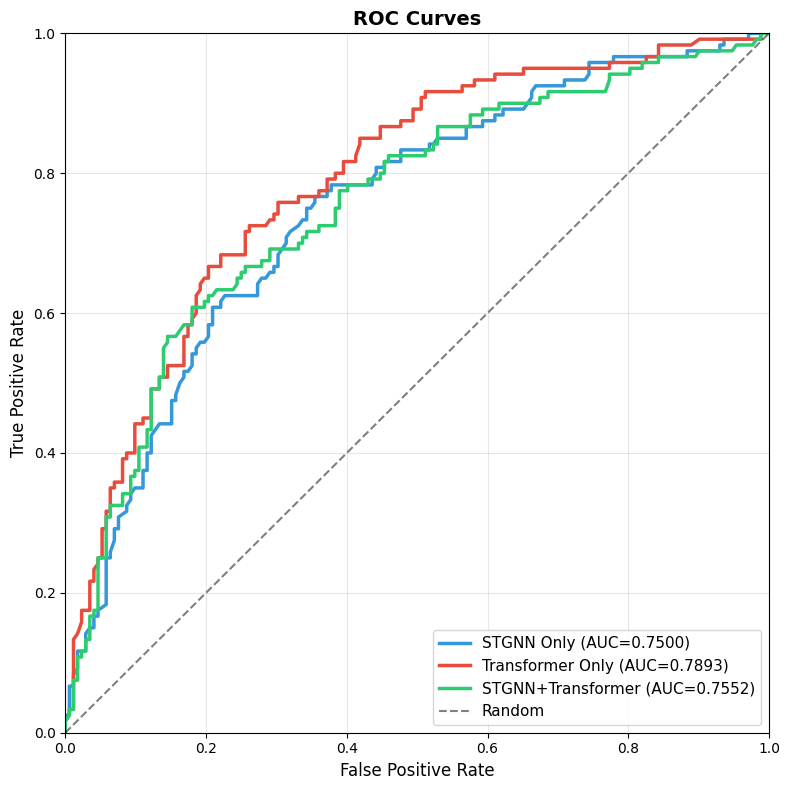

In [10]:
# Cell 10: ROC Curves
fig, ax = plt.subplots(figsize=(8, 8))

for idx, r in enumerate(results):
    fpr, tpr, _ = roc_curve(r['ys'], r['ps'])
    ax.plot(fpr, tpr, color=colors[idx], linewidth=2.5, 
            label=f"{labels[idx]} (AUC={r['best_auc']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1]); ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'benchmark_roc_curves.png', dpi=200, bbox_inches='tight')
plt.show()

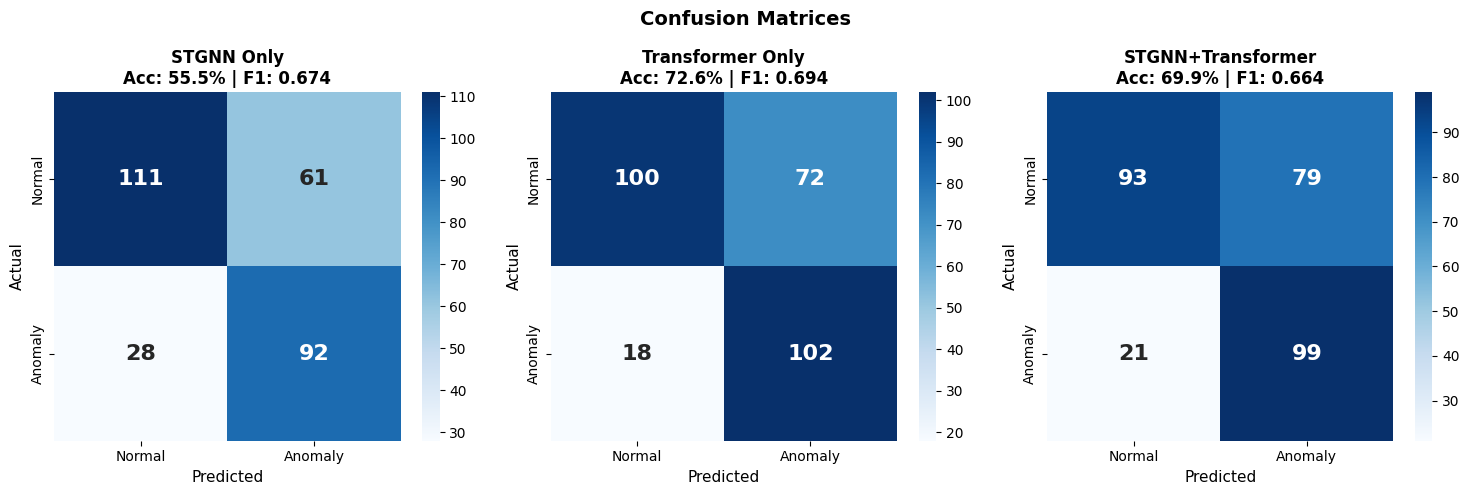

In [11]:
# Cell 11: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, r in enumerate(results):
    cm = confusion_matrix(r['ys'], r['preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
               annot_kws={'size': 16, 'weight': 'bold'})
    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_title(f"{labels[idx]}\nAcc: {r['accuracy']*100:.1f}% | F1: {r['best_f1']:.3f}", 
                        fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'benchmark_confusion_matrices.png', dpi=200, bbox_inches='tight')
plt.show()

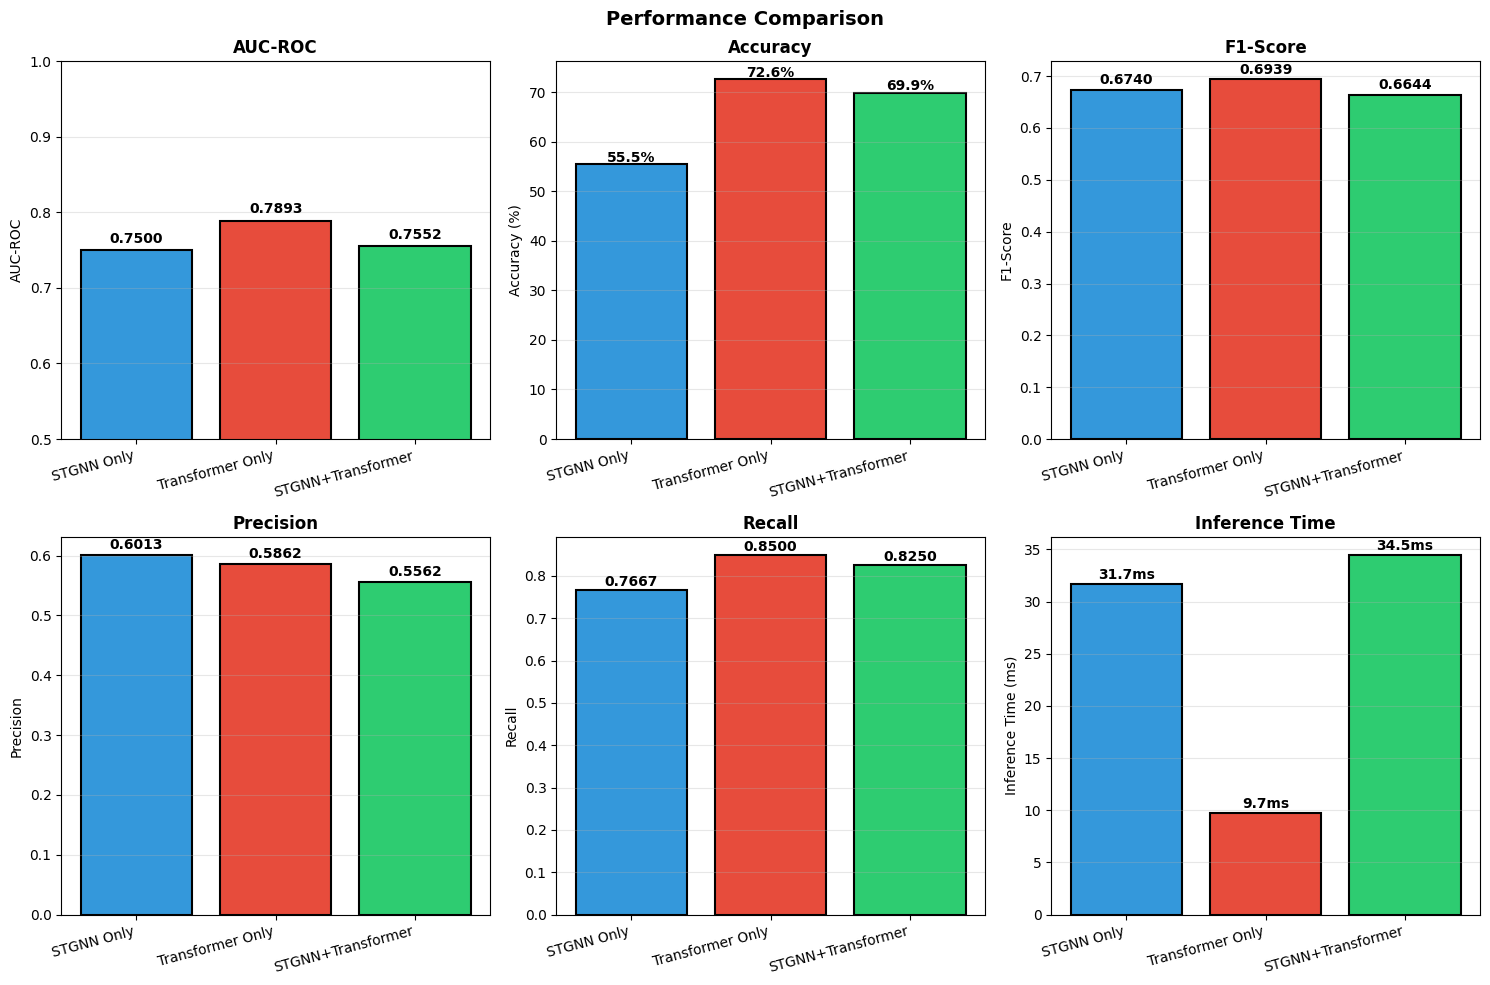

In [12]:
# Cell 12: Performance Bar Charts
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
x = np.arange(3)

# AUC-ROC
aucs = [r['best_auc'] for r in results]
axes[0,0].bar(x, aucs, color=colors, edgecolor='black', linewidth=1.5)
axes[0,0].set_ylabel('AUC-ROC'); axes[0,0].set_title('AUC-ROC', fontweight='bold')
axes[0,0].set_xticks(x); axes[0,0].set_xticklabels(labels, rotation=15, ha='right')
axes[0,0].set_ylim(0.5, 1.0); axes[0,0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(aucs): axes[0,0].text(i, v+0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Accuracy
accs = [r['accuracy']*100 for r in results]
axes[0,1].bar(x, accs, color=colors, edgecolor='black', linewidth=1.5)
axes[0,1].set_ylabel('Accuracy (%)'); axes[0,1].set_title('Accuracy', fontweight='bold')
axes[0,1].set_xticks(x); axes[0,1].set_xticklabels(labels, rotation=15, ha='right')
axes[0,1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accs): axes[0,1].text(i, v+0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# F1-Score
f1s = [r['best_f1'] for r in results]
axes[0,2].bar(x, f1s, color=colors, edgecolor='black', linewidth=1.5)
axes[0,2].set_ylabel('F1-Score'); axes[0,2].set_title('F1-Score', fontweight='bold')
axes[0,2].set_xticks(x); axes[0,2].set_xticklabels(labels, rotation=15, ha='right')
axes[0,2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(f1s): axes[0,2].text(i, v+0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Precision
precs = [r['precision'] for r in results]
axes[1,0].bar(x, precs, color=colors, edgecolor='black', linewidth=1.5)
axes[1,0].set_ylabel('Precision'); axes[1,0].set_title('Precision', fontweight='bold')
axes[1,0].set_xticks(x); axes[1,0].set_xticklabels(labels, rotation=15, ha='right')
axes[1,0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precs): axes[1,0].text(i, v+0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Recall
recs = [r['recall'] for r in results]
axes[1,1].bar(x, recs, color=colors, edgecolor='black', linewidth=1.5)
axes[1,1].set_ylabel('Recall'); axes[1,1].set_title('Recall', fontweight='bold')
axes[1,1].set_xticks(x); axes[1,1].set_xticklabels(labels, rotation=15, ha='right')
axes[1,1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(recs): axes[1,1].text(i, v+0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Inference Time
times = [r['mean_ms'] for r in results]
axes[1,2].bar(x, times, color=colors, edgecolor='black', linewidth=1.5)
axes[1,2].set_ylabel('Inference Time (ms)'); axes[1,2].set_title('Inference Time', fontweight='bold')
axes[1,2].set_xticks(x); axes[1,2].set_xticklabels(labels, rotation=15, ha='right')
axes[1,2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(times): axes[1,2].text(i, v+0.5, f'{v:.1f}ms', ha='center', fontweight='bold')

plt.suptitle('Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'benchmark_performance.png', dpi=200, bbox_inches='tight')
plt.show()

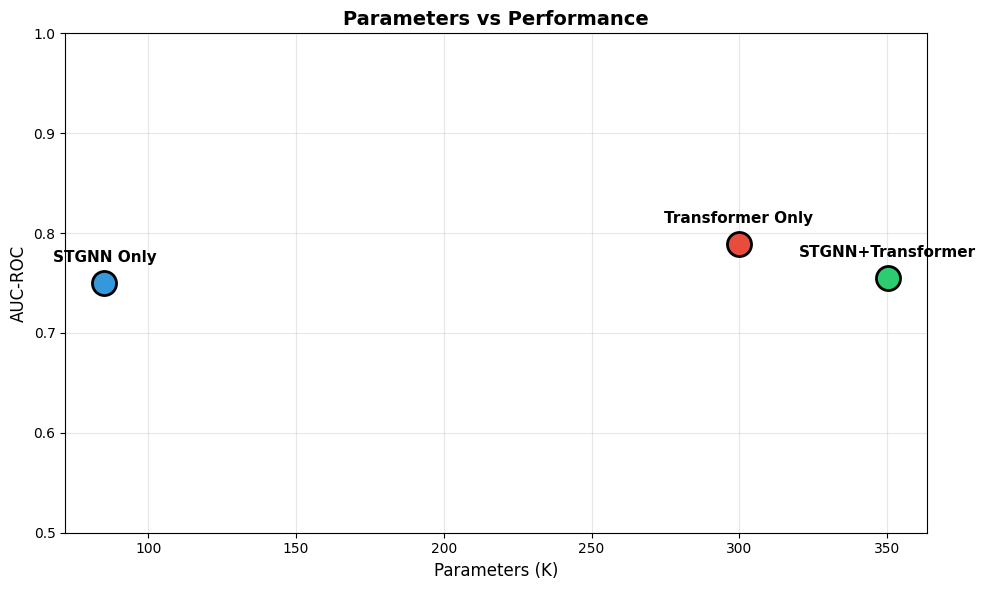

In [13]:
# Cell 13: Parameters vs Performance
fig, ax = plt.subplots(figsize=(10, 6))

params = [r['params']/1000 for r in results]
aucs = [r['best_auc'] for r in results]

for idx, r in enumerate(results):
    ax.scatter(params[idx], aucs[idx], s=300, c=colors[idx], edgecolor='black', linewidth=2, zorder=5)
    ax.annotate(labels[idx], (params[idx], aucs[idx]), 
                textcoords="offset points", xytext=(0,15), ha='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Parameters (K)', fontsize=12)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('Parameters vs Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'benchmark_params_vs_performance.png', dpi=200, bbox_inches='tight')
plt.show()

In [14]:
# Cell 14: Save Results
results_json = {
    'config': {
        'HIDDEN_DIM': HIDDEN_DIM,
        'NUM_GCN_LAYERS': NUM_GCN_LAYERS,
        'MAX_NODES': MAX_NODES,
        'MAX_SEGMENTS': MAX_SEGMENTS,
        'BATCH_ACCUM': BATCH_ACCUM,
        'EPOCHS': EPOCHS
    },
    'models': [
        {
            'name': r['model_name'],
            'params': r['params'],
            'accuracy': float(r['accuracy']),
            'auc_roc': float(r['best_auc']),
            'f1_score': float(r['best_f1']),
            'precision': float(r['precision']),
            'recall': float(r['recall']),
            'best_threshold': float(r['best_thr']),
            'inference_ms': float(r['mean_ms']),
            'fps': float(r['fps'])
        }
        for r in results
    ],
    'best_model': max(results, key=lambda x: x['best_auc'])['model_name']
}

with open(ANALYSIS_DIR / 'benchmark_results.json', 'w') as f:
    json.dump(results_json, f, indent=2)

print(f'Results saved to: {ANALYSIS_DIR / "benchmark_results.json"}')

Results saved to: DatasetTA\project_data\analysis\benchmark_results.json


In [17]:
# Cell 15: Final Summary
print('='*70)
print('KESIMPULAN BENCHMARK')
print('='*70)

print(f'\nConfig: HIDDEN_DIM={HIDDEN_DIM}, GCN_LAYERS={NUM_GCN_LAYERS}, MAX_NODES={MAX_NODES}, MAX_SEGMENTS={MAX_SEGMENTS}, BATCH_ACCUM={BATCH_ACCUM}')

sorted_results = sorted(results, key=lambda x: x['best_auc'], reverse=True)

print('\n' + '='*70)
print('RANKING BERDASARKAN AUC-ROC')
print('='*70)

for i, r in enumerate(sorted_results, 1):
    print(f"\n{i}. {r['model_name']} ({r['params']:,} params)")
    print(f"   AUC: {r['best_auc']:.4f} | Acc: {r['accuracy']*100:.2f}% | F1: {r['best_f1']:.4f}")
    print(f"   Prec: {r['precision']:.4f} | Recall: {r['recall']:.4f} | Threshold: {r['best_thr']:.4f}")
    print(f"   Inference: {r['mean_ms']:.2f}ms ({r['fps']:.1f} FPS)")

print('\n' + '='*70)
print(f"BEST MODEL: {sorted_results[0]['model_name']} (AUC: {sorted_results[0]['best_auc']:.4f})")
print('='*70)

print('\nFiles saved:')
for f in ['benchmark_training_history.png', 'benchmark_roc_curves.png', 
          'benchmark_confusion_matrices.png', 'benchmark_performance.png',
          'benchmark_params_vs_performance.png', 'benchmark_results.json']:
    print(f'  - {ANALYSIS_DIR / f}')

KESIMPULAN BENCHMARK

Config: HIDDEN_DIM=128, GCN_LAYERS=3, MAX_NODES=300, MAX_SEGMENTS=8, BATCH_ACCUM=4

RANKING BERDASARKAN AUC-ROC

1. Transformer Only (299,843 params)
   AUC: 0.7893 | Acc: 72.60% | F1: 0.6939
   Prec: 0.5862 | Recall: 0.8500 | Threshold: 0.4133
   Inference: 9.71ms (103.0 FPS)

2. STGNN + Transformer (350,147 params)
   AUC: 0.7552 | Acc: 69.86% | F1: 0.6644
   Prec: 0.5562 | Recall: 0.8250 | Threshold: 0.4370
   Inference: 34.49ms (29.0 FPS)

3. STGNN Only (85,187 params)
   AUC: 0.7500 | Acc: 55.48% | F1: 0.6740
   Prec: 0.6013 | Recall: 0.7667 | Threshold: 0.5977
   Inference: 31.71ms (31.5 FPS)

BEST MODEL: Transformer Only (AUC: 0.7893)

Files saved:
  - DatasetTA\project_data\analysis\benchmark_training_history.png
  - DatasetTA\project_data\analysis\benchmark_roc_curves.png
  - DatasetTA\project_data\analysis\benchmark_confusion_matrices.png
  - DatasetTA\project_data\analysis\benchmark_performance.png
  - DatasetTA\project_data\analysis\benchmark_params_vs

In [ ]:
# Cell 16: Node Importance Analysis
# Analisis node mana yang paling penting untuk prediksi model

@torch.no_grad()
def get_node_importance(model, graph_path, model_type='hybrid'):
    """
    Mendapatkan importance score untuk setiap node berdasarkan attention weights.
    model_type: 'stgnn', 'transformer', atau 'hybrid'
    """
    model.eval()
    g = torch.load(graph_path, weights_only=False)
    segs = split_segments(g)
    dev = next(model.parameters()).device
    
    all_importances = []
    all_positions = []
    
    for seg in segs:
        x = seg.x.to(dev)
        x_norm = norm_feat(x)
        
        # Get attention weights from encoder
        if model_type == 'transformer':
            h = model.enc(x_norm)
            att_logits = model.att(h).squeeze(-1)
        else:  # stgnn or hybrid
            if model_type == 'hybrid':
                h = model.stgnn.enc(x_norm)
                ei = seg.edge_index.to(dev) if seg.edge_index.numel() > 0 else torch.empty((2,0), dtype=torch.long, device=dev)
                for conv, ln in zip(model.stgnn.convs, model.stgnn.norms):
                    h = h + F.gelu(ln(conv(h, ei)))
                att_logits = model.stgnn.att(h).squeeze(-1)
            else:  # stgnn only
                h = model.enc(x_norm)
                ei = seg.edge_index.to(dev) if seg.edge_index.numel() > 0 else torch.empty((2,0), dtype=torch.long, device=dev)
                for conv, ln in zip(model.convs, model.norms):
                    h = h + F.gelu(ln(conv(h, ei)))
                att_logits = model.att(h).squeeze(-1)
        
        att_weights = torch.softmax(att_logits, dim=0).cpu().numpy()
        
        # Get positions (center of bounding boxes)
        positions = []
        for i in range(seg.x.size(0)):
            bbox = seg.x[i, :4].cpu().numpy()
            cx, cy = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
            positions.append((cx, cy))
        
        all_importances.extend(att_weights)
        all_positions.extend(positions)
    
    return np.array(all_importances), np.array(all_positions)

def visualize_node_importance(model, graph_path, model_name, model_type='hybrid', save_path=None):
    """Visualisasi node importance dengan scatter plot dan bar chart."""
    importances, positions = get_node_importance(model, graph_path, model_type)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Scatter plot dengan posisi node
    scatter = axes[0].scatter(positions[:, 0], positions[:, 1], 
                              c=importances, cmap='YlOrRd', 
                              s=50, alpha=0.8, edgecolors='black', linewidth=0.5)
    axes[0].set_xlabel('X Position (pixels)', fontsize=11)
    axes[0].set_ylabel('Y Position (pixels)', fontsize=11)
    axes[0].set_title(f'Node Importance: {graph_path.stem.replace("_graph", "")}', fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()  # Invert Y untuk match dengan koordinat gambar
    plt.colorbar(scatter, ax=axes[0], label='Importance')
    
    # Right: Top 10 important nodes
    top_k = min(10, len(importances))
    top_indices = np.argsort(importances)[-top_k:][::-1]
    top_importances = importances[top_indices]
    
    bars = axes[1].bar(range(top_k), top_importances, color='#3498db', edgecolor='black')
    axes[1].set_xlabel('Node Index', fontsize=11)
    axes[1].set_ylabel('Importance', fontsize=11)
    axes[1].set_title(f'Top {top_k} Important Nodes ({model_name})', fontsize=12, fontweight='bold')
    axes[1].set_xticks(range(top_k))
    axes[1].set_xticklabels(top_indices)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f'✅ Saved: {save_path}')
    
    plt.show()
    
    return importances, positions

# Load models dan analisis node importance
print('='*70)
print('NODE IMPORTANCE ANALYSIS')
print('='*70)

# Pilih sample video (1 anomaly, 1 normal)
graph_files = list(GRAPHS_DIR.rglob('*_graph.pt'))
anom_graphs = [g for g in graph_files if any(c in str(g) for c in ANOM_CLASSES)]
norm_graphs = [g for g in graph_files if not any(c in str(g) for c in ANOM_CLASSES)]

sample_graphs = []
if anom_graphs: sample_graphs.append(('Anomaly', anom_graphs[0]))
if norm_graphs: sample_graphs.append(('Normal', norm_graphs[0]))

# Analisis untuk setiap model
model_configs = [
    ('STGNN Only', STGNNOnly, 'stgnn', 'benchmark_stgnn_only.pt'),
    ('Transformer Only', TransformerOnly, 'transformer', 'benchmark_transformer_only.pt'),
    ('STGNN + Transformer', STGNNTransformer, 'hybrid', 'benchmark_stgnn___transformer.pt')
]

for model_name, ModelClass, model_type, weight_file in model_configs:
    weight_path = MODELS_DIR / weight_file
    if not weight_path.exists():
        print(f'⚠️ Weights not found: {weight_file}')
        continue
    
    print(f'\n📊 {model_name}')
    model = ModelClass()
    model.load_state_dict(torch.load(weight_path, weights_only=True))
    model = model.to(DEVICE)
    model.eval()
    
    for label, graph_path in sample_graphs:
        print(f'   Analyzing: {label} - {graph_path.stem}')
        save_name = f'node_importance_{model_type}_{label.lower()}.png'
        visualize_node_importance(model, graph_path, model_name, model_type, 
                                  save_path=ANALYSIS_DIR / save_name)
    
    del model
    torch.cuda.empty_cache()

print('\n✅ Node Importance Analysis Complete!')